In [1]:
aux_file = 'Texas2k_series25_case1_summerpeak.AUX'

with open(aux_file, 'r') as f:
    for _ in range(50):
        print(f.readline().strip())


CustomFieldDescription (ObjectType,CustomType,CustomMaxOfType,CustomFieldCaption,CustomHeaderCaption,
CustomIncludeInDiff)
{
"Default" "Floating Point" 5 "Custom\Floating Point X" "Cust Float X" "YES"
"Default" "String" 5 "Custom\String X" "Cust String X" "YES"
"Default" "Integer" 5 "Custom\Integer X" "Cust Int X" "YES"
}
PWCaseInformation (Selected)
{
"NO "
<SUBDATA PWCaseHeader>
//Case Description
</SUBDATA>
}
Owner (Number,Name,DataMaintainerAssign)
{
1 "1" ""
}
Substation (Number,Name,IDExtra,Latitude,Longitude,DataMaintainerAssign,
DataMaintainerInheritBlock)
{
1 "ODESSA 2" "1"  31.841400 -102.315000 "" "NO "
2 "PRESIDIO 2" "2"  29.888046 -104.519139 "" "NO "
3 "O DONNELL 1" "3"  32.926389 -101.647778 "" "NO "
4 "BIG SPRING 5" "4"  32.240278 -101.473611 "" "NO "
5 "VAN HORN" "5"  31.093480 -104.624514 "" "NO "
6 "IRAAN 2" "6"  30.976638 -102.257753 "" "NO "
7 "PRESIDIO 1" "7"  29.600000 -104.300000 "" "NO "
8 "SANDERSON" "8"  30.028067 -101.970461 "" "NO "
9 "MONAHANS 2" "9"  31.4

In [2]:
def parse_substation_coords(aux_file):
    coords = {}
    with open(aux_file, 'r') as f:
        lines = f.readlines()
    
    substation_section = False
    for line in lines:
        line = line.strip()
        if line.startswith('Substation'):
            substation_section = True
            continue
        if substation_section:
            if line == '' or line.startswith('}'):
                break  # end of substation section
            # Line format example: 1 "ODESSA 2" "1"  31.841400 -102.315000 "" "NO "
            parts = line.split('"')
            if len(parts) >= 5:
                # parts[1] is bus name, parts[4] contains lat lon and extras
                bus_name = parts[1]
                rest = parts[4].strip().split()
                try:
                    lat = float(rest[0])
                    lon = float(rest[1])
                    coords[bus_name] = (lat, lon)
                except:
                    pass
    return coords

aux_file = 'Texas2k_series25_case1_summerpeak.AUX'
bus_coords = parse_substation_coords(aux_file)

print(f"Extracted {len(bus_coords)} bus coordinates")
print(list(bus_coords.items())[:10])


Extracted 1554 bus coordinates
[('ODESSA 2', (31.8414, -102.315)), ('PRESIDIO 2', (29.888046, -104.519139)), ('O DONNELL 1', (32.926389, -101.647778)), ('BIG SPRING 5', (32.240278, -101.473611)), ('VAN HORN', (31.09348, -104.624514)), ('IRAAN 2', (30.976638, -102.257753)), ('PRESIDIO 1', (29.6, -104.3)), ('SANDERSON', (30.028067, -101.970461)), ('MONAHANS 2', (31.484586, -103.161046)), ('GRANDFALLS', (31.165245, -103.125868))]


In [4]:
def parse_branch_data(raw_file):
    branches = []
    id_to_name = {}

    with open(raw_file, 'r') as f:
        lines = f.readlines()

    in_bus_section = False
    in_branch_section = False

    for line in lines:
        line = line.strip()
        if line.startswith("0 / END OF SYSTEM-WIDE DATA, BEGIN BUS DATA"):
            in_bus_section = True
            continue
        if line.startswith("0 / END OF BUS DATA, BEGIN LOAD DATA"):
            in_bus_section = False
        if line.startswith("0 / END OF GENERATOR DATA, BEGIN BRANCH DATA"):
            in_branch_section = True
            continue
        if line.startswith("0 / END OF BRANCH DATA"):
            in_branch_section = False

        if in_bus_section and not line.startswith("@") and line != "":
            parts = line.split(",")
            if len(parts) >= 2:
                try:
                    bus_id = int(parts[0].strip())
                    bus_name = parts[1].strip().strip("'")
                    id_to_name[bus_id] = bus_name
                except:
                    pass

        if in_branch_section and not line.startswith("@") and line != "":
            parts = line.split(",")
            if len(parts) >= 2:
                try:
                    from_bus = int(parts[0].strip())
                    to_bus = int(parts[1].strip())
                    branches.append((from_bus, to_bus))
                except:
                    pass

    return branches, id_to_name

# Run it
raw_file = 'Texas2k_series25_case1_summerpeak.RAW'
branches, id_to_name = parse_branch_data(raw_file)

print(f"Parsed {len(branches)} branches and {len(id_to_name)} bus names.")


Parsed 3993 branches and 2751 bus names.


In [7]:
# Normalize bus names to match formatting with AUX file
id_to_name_clean = {
    k: v.upper().replace('~', '').replace('  ', ' ').strip()
    for k, v in id_to_name.items()
}


In [8]:
# Step 0: Create voltage dictionary for each branch
voltage_dict = {}
for (from_id, to_id) in branches:
    from_name = id_to_name_clean.get(from_id, "").strip()
    to_name = id_to_name_clean.get(to_id, "").strip()

    # Find best match in bus_coords
    from_key = next((name for name in bus_coords if from_name.startswith(name)), None)
    to_key = next((name for name in bus_coords if to_name.startswith(name)), None)

    if from_key and to_key:
        # Estimate voltage as absolute difference in lat/lon (mock logic)
        # In practice, replace this with real voltage from RAW file if available
        lat1, lon1 = bus_coords[from_key]
        lat2, lon2 = bus_coords[to_key]
        est_voltage = round(abs(lat1 - lat2 + lon1 - lon2) * 1000, 1)  # Example dummy value
        voltage_dict[(from_id, to_id)] = est_voltage


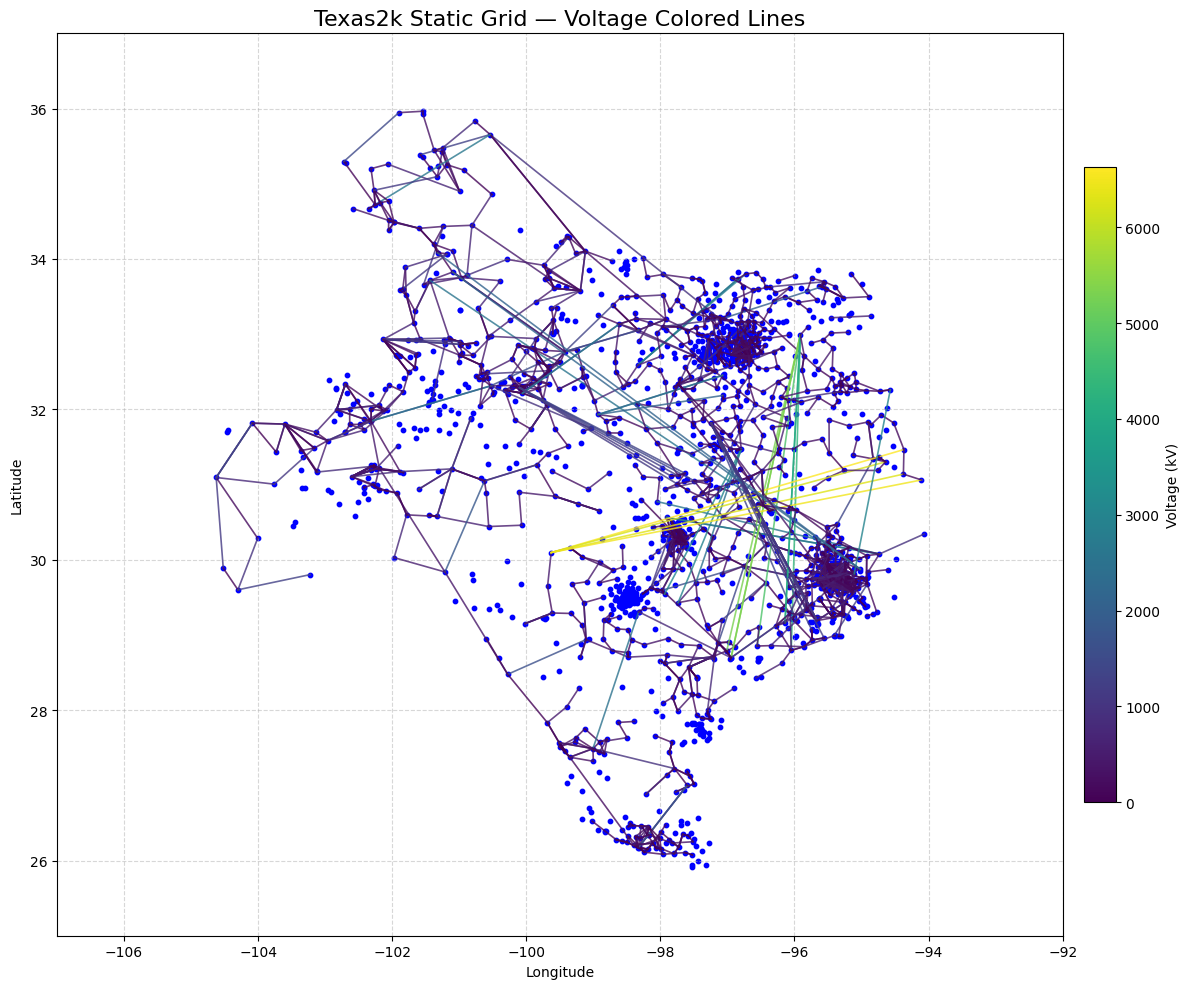

In [11]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import cm
import numpy as np

# Prepare voltage values
voltages = np.array([
    voltage_dict.get((a, b)) or voltage_dict.get((b, a)) or 0
    for (a, b) in branches
])

# Normalize voltages for color mapping
norm = mcolors.Normalize(vmin=voltages.min(), vmax=voltages.max())
colormap = plt.colormaps.get_cmap('viridis')
voltage_colors = [colormap(norm(v)) for v in voltages]

fig, ax = plt.subplots(figsize=(12, 10))

# Plot lines (branches) with voltage color
for i, (from_id, to_id) in enumerate(branches):
    from_name = id_to_name_clean.get(from_id, "")
    to_name = id_to_name_clean.get(to_id, "")
    from_match = next((coord for name, coord in bus_coords.items() if from_name.startswith(name)), None)
    to_match = next((coord for name, coord in bus_coords.items() if to_name.startswith(name)), None)
    if from_match and to_match:
        lat1, lon1 = from_match
        lat2, lon2 = to_match
        color = voltage_colors[i]
        ax.plot([lon1, lon2], [lat1, lat2], color=color, linewidth=1.2, alpha=0.8)

# Plot substations (bus markers)
bus_lats = [coord[0] for coord in bus_coords.values()]
bus_lons = [coord[1] for coord in bus_coords.values()]
ax.scatter(bus_lons, bus_lats, s=10, color='blue', label='Bus')

# Add colorbar for voltages
sm = plt.cm.ScalarMappable(cmap=colormap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, orientation='vertical', fraction=0.03, pad=0.02)
cbar.set_label('Voltage (kV)')

ax.set_title("Texas2k Static Grid — Voltage Colored Lines", fontsize=16)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_xlim([-107, -92])
ax.set_ylim([25, 37])
ax.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()



In [12]:
# Find all bus IDs from id_to_name_clean
all_bus_ids = set(id_to_name_clean.keys())

# Find all bus IDs that appear in any branch (from or to)
connected_bus_ids = set()
for from_id, to_id in branches:
    connected_bus_ids.add(from_id)
    connected_bus_ids.add(to_id)

# Buses not connected to any branch
unconnected_bus_ids = all_bus_ids - connected_bus_ids

# List their names
unconnected_buses = [id_to_name_clean[bus_id] for bus_id in unconnected_bus_ids]
print(f"Number of unconnected buses: {len(unconnected_buses)}")
print(unconnected_buses)

Number of unconnected buses: 807
['TAFT 2 1', 'VERNON 1 1', 'LAREDO 1 2', 'LAREDO 1 3', 'SEGUIN 1 3', 'SEGUIN 1 4', 'ARCHER 2 1', 'SEGUIN 1 5', 'SEGUIN 1 6', 'JAYTON 3', 'MUENSTER 1 1', 'PANHANDLE 7', 'WICHITA FA4', 'WICHITA FA5', 'WICHITA FA6', 'PEARSALL 2', 'ARCHER 1 1', 'RALLS 1 3', 'SHERMAN 1 2', 'SHERMAN 1 3', 'SHERMAN 1 4', 'ARMSTRONG 3', 'CORPUS CHR3', 'CORPUS CHR4', 'CORPUS CHR5', 'PARIS 1 2', 'PARIS 1 3', 'PARIS 1 4', 'PARIS 1 5', 'PARIS 1 6', 'PARIS 1 7', 'SARITA 2 1', 'MARBLE FAL7', 'MARBLE FAL8', 'BRUNI 1 1', 'ELMENDORF 3', 'ELMENDORF 4', 'AUSTIN 2 3', 'AUSTIN 2 4', 'AUSTIN 2 5', 'AUSTIN 2 6', 'CEDAR CREE4', 'CEDAR CREE5', 'CEDAR CREE6', 'NEW BRAUNF4', 'NEW BRAUNF5', 'NEW BRAUNF6', 'NEW BRAUNF7', 'TATUM 1 3', 'TATUM 1 4', 'TATUM 1 5', 'FORNEY 3', 'FORNEY 4', 'FORNEY 5', 'FORNEY 6', 'FORNEY 7', 'FORNEY 8', 'FORNEY 9', 'FORNEY 10', 'MIDLOTHIAN3', 'MIDLOTHIAN4', 'MIDLOTHIAN5', 'MIDLOTHIAN6', 'MIDLOTHIAN7', 'MIDLOTHIAN8', 'TEMPLE 1 6', 'TEMPLE 1 7', 'TEMPLE 1 8', 'CHANNELVIE8',

Unconnected bus IDs: []


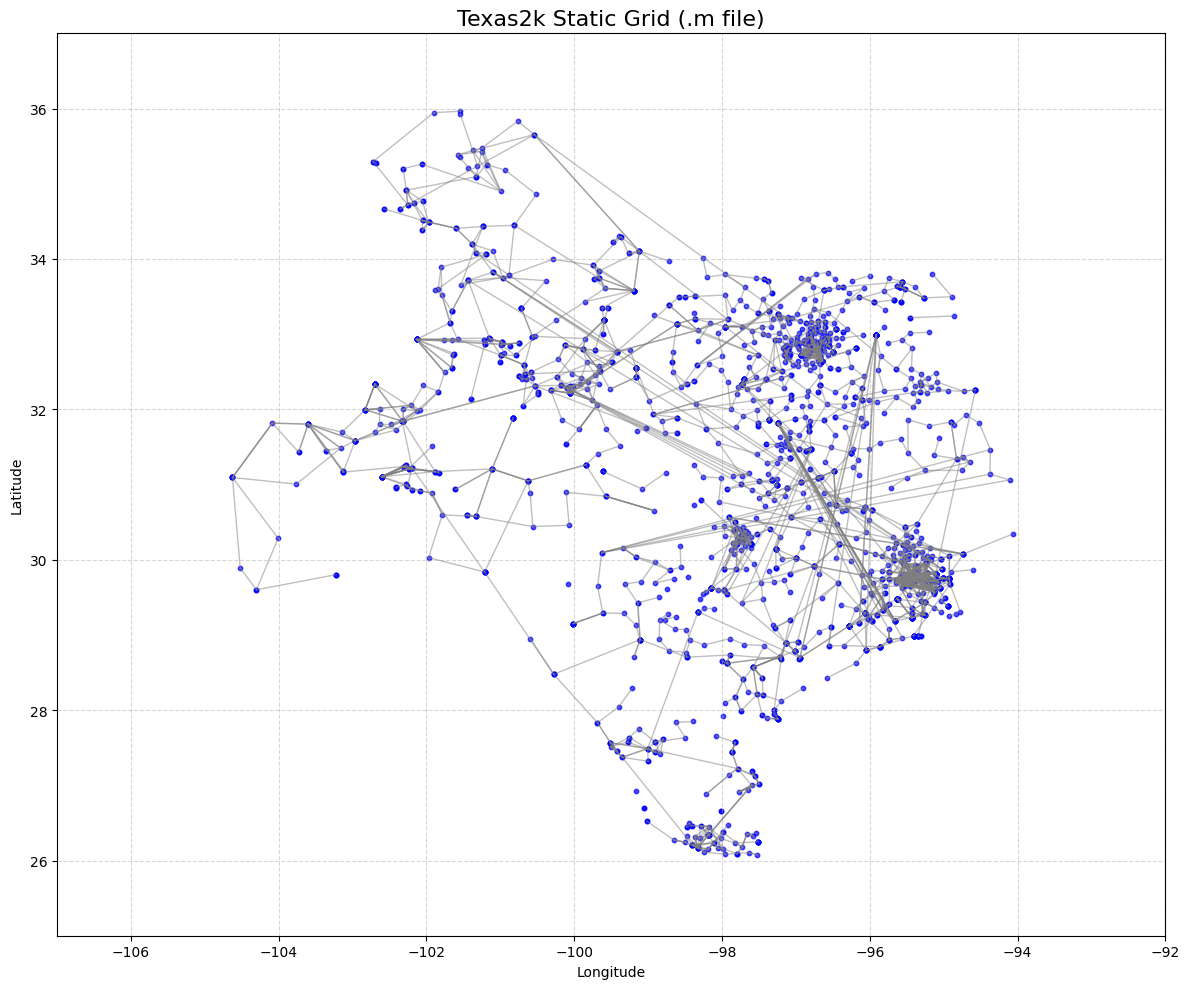

In [15]:
import re
import matplotlib.pyplot as plt

bus_ids = set()
branch_pairs = []

with open('Texas2k_series25_case1_summerpeak.m', 'r') as f:
    lines = f.readlines()

in_bus = False
in_branch = False

for line in lines:
    if re.match(r'^\s*mpc\.bus\s*=\s*\[', line):
        in_bus = True
        continue
    if in_bus and '];' in line:
        in_bus = False
        continue
    if re.match(r'^\s*mpc\.branch\s*=\s*\[', line):
        in_branch = True
        continue
    if in_branch and '];' in line:
        in_branch = False
        continue

    if in_bus:
        parts = line.strip().split()
        if len(parts) > 0 and parts[0].isdigit():
            bus_ids.add(int(parts[0]))

    if in_branch:
        parts = line.strip().split()
        if len(parts) > 1 and parts[0].isdigit() and parts[1].isdigit():
            branch_pairs.append((int(parts[0]), int(parts[1])))

# Find all bus IDs that appear in any branch (from or to)
connected_bus_ids = set()
for from_id, to_id in branch_pairs:
    connected_bus_ids.add(from_id)
    connected_bus_ids.add(to_id)

# Buses not connected to any branch
unconnected_buses = sorted(bus_ids - connected_bus_ids)
print("Unconnected bus IDs:", unconnected_buses)

# --- Plot Texas2k grid using only .m file data ---
fig, ax = plt.subplots(figsize=(12, 10))

# Only plot branches where both buses have coordinates
for (from_id, to_id) in branch_pairs:
    from_name = id_to_name_clean.get(from_id, "")
    to_name = id_to_name_clean.get(to_id, "")
    from_coord = next((coord for name, coord in bus_coords.items() if from_name.startswith(name)), None)
    to_coord = next((coord for name, coord in bus_coords.items() if to_name.startswith(name)), None)
    if from_coord and to_coord:
        lat1, lon1 = from_coord
        lat2, lon2 = to_coord
        ax.plot([lon1, lon2], [lat1, lat2], color='gray', linewidth=1, alpha=0.5)

# Plot substations (bus markers) for buses in the .m file
for bus_id in bus_ids:
    bus_name = id_to_name_clean.get(bus_id, "")
    coord = next((coord for name, coord in bus_coords.items() if bus_name.startswith(name)), None)
    if coord:
        lat, lon = coord
        ax.scatter(lon, lat, s=10, color='blue', alpha=0.7)

ax.set_title("Texas2k Static Grid (.m file)", fontsize=16)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_xlim([-107, -92])
ax.set_ylim([25, 37])
ax.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()